# Viewing and manipulating FITS images

## Authors
Originally written by Lia Corrales, modified by Patrick Sheehan for the CIERA HS Summer Program

## Keywords
matplotlib, FITS image, table

## Summary

This tutorial demonstrates the use of `astropy.utils.data` to download a data file, then uses `astropy.io.fits` to open the file, and lastly uses `matplotlib` to view the image with different color scales and stretches and to make histograms. In this tutorial we've also included a demonstration of simple image stacking.

In [1]:
import numpy as np

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits

The following cell is needed to download the example FITS files used here.

In [2]:
from astropy.utils.data import download_file
image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )

## Opening FITS files and loading the image data

Let's open the FITS file to find out what it contains.

In [3]:
hdu_list = fits.open(image_file)
hdu_list.info()

Filename: /Users/psheehan/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Generally, the image information is located in the <code>PRIMARY</code> block. The blocks are numbered and can be accessed by indexing <code>hdu_list</code>.

In [4]:
image_data = hdu_list[0].data

Our data is now stored as a 2-D numpy array.  But how do we know the dimensions of the image?  We can simply look at the `shape` of the array.

In [5]:
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


We can also get information about the image from what we call the "Header":

In [6]:
header = hdu_list[0].header
header

SIMPLE  =                    T /FITS: Compliance                                
BITPIX  =                   16 /FITS: I*2 Data                                  
NAXIS   =                    2 /FITS: 2-D Image Data                            
NAXIS1  =                  891 /FITS: X Dimension                               
NAXIS2  =                  893 /FITS: Y Dimension                               
EXTEND  =                    T /FITS: File can contain extensions               
DATE    = '2014-01-09        '  /FITS: Creation Date                            
ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                
SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                
REGION  = 'ER768   '           /GSSS: Region Name                               
PLATEID = 'A0JP    '           /GSSS: Plate ID                                  
SCANNUM = '01      '           /GSSS: Scan Number                               
DSCNDNUM= '00      '        

We can access elements of the header by indexing the header object with the header keyword. For example, here's how we could get the date of the observation:

In [7]:
header["DATE-OBS"]

'1990-12-22T13:49:00'

Great! At this point, we can close the FITS file because we've stored everything we wanted to a variable.

In [8]:
hdu_list.close()

### SHORTCUT

If you don't need to examine the FITS header, you can call `fits.getdata` to bypass the previous steps.

In [9]:
image_data = fits.getdata(image_file)
print(type(image_data))
print(image_data.shape)

<class 'numpy.ndarray'>
(893, 891)


If you do need to examine the header, you can still access both in one single call:

In [10]:
image_data, image_header = fits.getdata(image_file, header=True)
print(type(image_data))
print(image_data.shape)
print(image_header["DATE-OBS"])

<class 'numpy.ndarray'>
(893, 891)
1990-12-22T13:49:00


## Viewing the image data and getting basic statistics

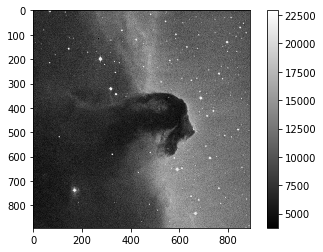

In [11]:
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# To see more color maps
# http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps

Let's get some basic statistics about our image:

In [12]:
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Min: 3759
Max: 22918
Mean: 9831.481676287574
Stdev: 3032.3927542049046


### Adding astronomical coordinates with WCS

FITS image files typically come with information in their headers about the coordinates of the image following he World Coordinate System (WCS) standards (see https://fits.gsfc.nasa.gov/fits_wcs.html). Astropy knows how to handle this information with the `astropy.wcs` sub-package. To use it we first import the necessary packages:

In [26]:
from astropy.wcs import WCS

To make use of this information, we need to extract it from the header:

In [32]:
wcs = WCS(image_header)

Finally, we can make a figure that uses the WCS information to adjust the projection of the image:

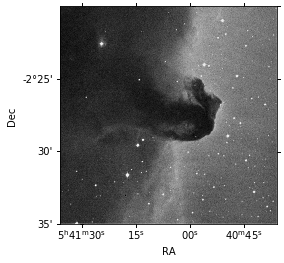

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':wcs})

ax.imshow(image_data, origin="lower", cmap="gray")

ax.set_xlabel('RA')
ax.set_ylabel('Dec')

### Plotting a histogram

To make a histogram with `matplotlib.pyplot.hist()`, we'll need to cast the data from a 2-D array to something one dimensional.

In this case, let's use the `ndarray.flatten()` to return a 1-D numpy array.

In [13]:
print(type(image_data.flatten()))
print(image_data.flatten().shape)

<class 'numpy.ndarray'>
(795663,)


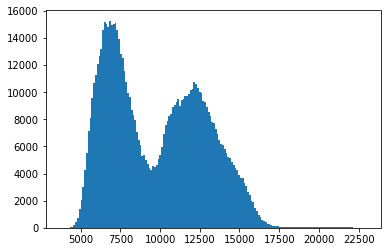

In [14]:
histogram = plt.hist(image_data.flatten(), bins='auto')

### Displaying the image with a logarithmic scale

What if we want to use a logarithmic color scale? To do so, we'll need to load the `LogNorm` object from `matplotlib`.

In [15]:
from matplotlib.colors import LogNorm

[Text(1, 0, '5,000'), Text(1, 0, '10,000'), Text(1, 0, '20,000')]

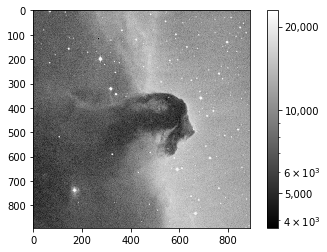

In [16]:
plt.imshow(image_data, cmap='gray', norm=LogNorm())

# I chose the tick marks based on the histogram above
cbar = plt.colorbar(ticks=[5.e3,1.e4,2.e4])
cbar.ax.set_yticklabels(['5,000','10,000','20,000'])

### Astropy visualization tools

Astropy also provides a wider range of tools for stretching images. You can find these in the `astropy.visualization` sub-package. For example, we can use a stretch based on the sinh function:

In [17]:
from astropy.visualization import SinhStretch, ImageNormalize, MinMaxInterval

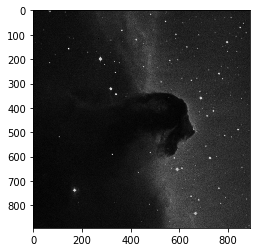

In [18]:
stretch = ImageNormalize(image_data, interval=MinMaxInterval(), stretch=SinhStretch())

plt.imshow(image_data, cmap='gray', norm=stretch)

You can go to the Astropy documentation for `astropy.visualization` to find many more stretches!

## Basic image math: image stacking

You can also perform math with the image data like any other numpy array.  In this particular example, we'll stack several images of M13 taken with a ~10'' telescope.

Let's start by opening a series of FITS files and store the data in a list, which we've named `image_concat`.

In [19]:
base_url = 'http://data.astropy.org/tutorials/FITS-images/M13_blue_{0:04d}.fits'

image_list = []
for n in range(1, 5+1):
    image_list.append(download_file(base_url.format(n), cache=True))

image_concat = [fits.getdata(image) for image in image_list]

Now we'll stack the images by summing the concatenated list.

In [20]:
# The long way
final_image = np.zeros(shape=image_concat[0].shape)

for image in image_concat:
    final_image += image

# The short way
# final_image = np.sum(image_concat, axis=0)

We're going to show the image, but need to decide on the best stretch. To do so let's plot a histogram of the data.

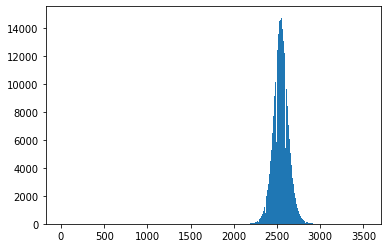

In [21]:
image_hist = plt.hist(final_image.flatten(), bins='auto')

We'll use the keywords `vmin` and `vmax` to set limits on the color scaling for `imshow`.

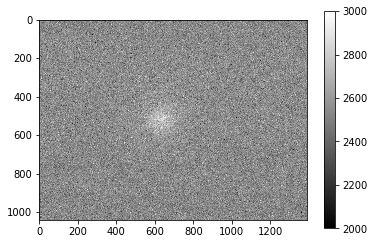

In [22]:
plt.imshow(final_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

## Image slicing (zooming)

We are pretty far zoomed out from the object in the above image. We can create a sub-image to try and look at it zoomed-in. Looks like the object goes from about 500 to 800 in the x direction, and 400 to 700 in the y direction. We can create a sub-image to zoom in on that area:

In [23]:
sub_image = final_image[400:700,500:800]

Notice how the y-direction comes first? This is a quirk of Python/Numpy. Now make a plot to see what we did:

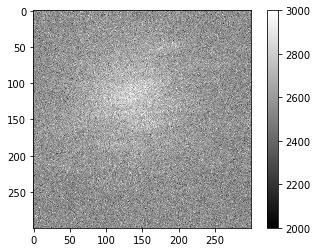

In [24]:
plt.imshow(sub_image, cmap='gray', vmin=2E3, vmax=3E3)
plt.colorbar()

## Writing image data to a FITS file

We can easily do this with the `writeto()` method.

Warning: you'll receive an error if the file you are trying to write already exists.  That's why we've set `overwrite=True`.

In [25]:
outfile = 'stacked_M13_blue.fits'

hdu = fits.PrimaryHDU(final_image)
hdu.writeto(outfile, overwrite=True)

## Exercises

Go to this webpage, https://bulk.cv.nrao.edu/almadata/lp/DSHARP/images/, and download one of the files ending in _continuum.fits. Read it in with Astropy, and make a plot of the image. Make sure you grab the header when you read in the data! You'll need it later.

That may not look like much. Try changing the image to be shown in a different stretch. Try applying one of the stretches from `astropy.visualization` to the image. Look any different? Why? Can you find one that shows all of the features in the image nicely? You can also change the colormap of the image. Go to this webpage, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html, and pick a different colormap to show the image in.

You can zoom in on the image by appropriately slicing the image using the image_data[xmin:xmax,ymin:ymax] syntax. Use this to zoom in on the object at the center of the image in a new plot. Adjust it until it looks good. Notice anything?

Now, repeat these steps on a different _continuum image from the webpage above. Adjust the zoom and normalization until the image looks good. Does this object look the same as the one you just played with?

Now lets look at the header. What was the date of the observation?

Change the date/time of the observation to something else, and save the file as "new_file.fits".

CHALLENGE! Matplotlib has a feature called Patches, which allow you to add shapes to your plot. Look up `matplotlib.patches.Ellipse` and try to generate an ellipse to put on your plot with `ax.add_artist`. Can you make the ellipse match the shape of one of the dark rings in the image?

Based on the height and width of the ellipse, how big is the dark ring that you just matched with the ellipse? (Hint: 1 AU is equal to 1 arcsecond at 1 pc, and these sources are typically at 140 pc. You can find the pixel size in radians in the Header).

## Additional Material

Astropy has a number of other features, and plenty of tutorials to go through. You can find all of this material at:
- Astropy: https://www.astropy.org
- Documentation: http://docs.astropy.org/en/stable/index.html
- Tutorials: http://learn.astropy.org/tutorials.html